# Geographical Field Location Prediction Example
This is based on parts of the caffe2 MNIST tutorials at https://github.com/caffe2/tutorials/blob/master/create_your_own_dataset.ipynb and https://github.com/caffe2/tutorials/blob/master/MNIST.ipynb and uses six public NASA satellite images.



In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import skimage
from skimage import io

In [3]:
from sklearn.feature_extraction import image

In [4]:
import os

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import numpy as np
from matplotlib import pyplot
from StringIO import StringIO
import operator

from caffe2.proto import caffe2_pb2
import caffe2.python.predictor.predictor_exporter as pe
from caffe2.python import (
    brew,
    core,
    utils,
    model_helper,
    net_drawer,
    optimizer,
    visualize,
    workspace,
)

# Load Field Images
There are six images of fields in different geographical locations.  They look different and we will train a LeNet to distinguish patches between the locations using caffe2.

In [6]:
[_ for _ in os.listdir('data') if _.endswith('.png')]

[u'Bolivia.png',
 u'Germany.png',
 u'Brazil.png',
 u'MN.png',
 u'KS.png',
 u'Thailand.png']

In [7]:
from caffe2.python import visualize

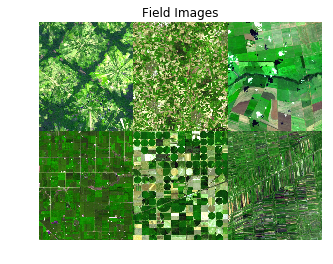

In [8]:
images = []
for filename in os.listdir('data'):
    if filename.endswith('.png'):
        img = io.imread('data/%s'%filename)
        images.append(img[:,:,:3].tolist())
images = np.array(images)
images = np.moveaxis(images,3,1)
pyplot.figure()
pyplot.title("Field Images")
_ = visualize.NCHW.ShowMultiple(images/255.0)

### Extract random 60x60 RGB patches from each image

In [9]:
np.random.seed(123)
features = []
str_labels = []
for filename in os.listdir('data'):
    if filename.endswith('.png'):
        img = io.imread('data/%s'%filename)
        patches = image.extract_patches_2d(img, (60, 60), 1000)[:,:,:,:3]
        features += patches.tolist()
        str_labels += [filename.split('.')[0]]*len(patches)
features = np.array(features)
str_labels = np.array(str_labels)

### Convert to NCWH format

In [10]:
features = np.moveaxis(features,3,1)

In [11]:
features.shape,str_labels.shape

((6000, 3, 60, 60), (6000,))

### Check some patches
Each of these patches come from a known geographical location.  The LeNet will learn to predict where a patch came from.

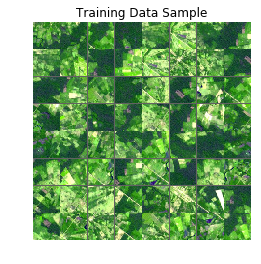

In [12]:
pyplot.figure()
pyplot.title("Training Data Sample")
_ = visualize.NCHW.ShowMultiple(features[:64]/255.0)

### Build a mapping from location to unique integer id
The integers in labels will be used by caffe2 for one-hot-encoding later.

In [13]:
loc2id = dict(zip(sorted(set(str_labels)),range(len(set(str_labels)))))
loc2id

{u'Bolivia': 0,
 u'Brazil': 1,
 u'Germany': 2,
 u'KS': 3,
 u'MN': 4,
 u'Thailand': 5}

In [56]:
id2loc = dict(zip(range(len(set(str_labels))),sorted(set(str_labels))))
id2loc

{0: u'Bolivia',
 1: u'Brazil',
 2: u'Germany',
 3: u'KS',
 4: u'MN',
 5: u'Thailand'}

In [14]:
labels = np.array([loc2id[_] for _ in str_labels])

## Extract a random set of patches for training
Use the rest for testing

In [15]:
np.random.seed(123)

random_index = np.random.permutation(len(str_labels))
features = features[random_index]
labels = labels[random_index]

ntrain = 2000
ntest = len(features)-ntrain

train_features = features[:ntrain]
train_labels = labels[:ntrain]
test_features = features[ntrain:]
test_labels = labels[ntrain:]

ntrain,ntest

(2000, 4000)

### Write the train and test sets to minidb files
Caffe2 will use these as inputs

In [16]:
data_folder = os.path.join('data')
train_path = os.path.join(data_folder,'geo_train.minidb')
test_path = os.path.join(data_folder,'geo_test.minidb')

In [17]:
def write_db(db_type, db_name, features, labels):
    if os.path.exists(db_name):
        os.unlink(db_name)
    db = core.C.create_db(db_type, db_name, core.C.Mode.write)
    transaction = db.new_transaction()
    for i in range(features.shape[0]):
        feature_and_label = caffe2_pb2.TensorProtos()
        feature_and_label.protos.extend([
            utils.NumpyArrayToCaffe2Tensor(features[i]),
            utils.NumpyArrayToCaffe2Tensor(labels[i])])
        transaction.put(
            'train_%03d'.format(i),
            feature_and_label.SerializeToString())
    # Close the transaction, and then close the db.
    del transaction
    del db

write_db("minidb", train_path, train_features, train_labels)
write_db("minidb", test_path, test_features, test_labels)

## Define functions derived from caffe2 MNIST tutorial
https://github.com/caffe2/tutorials/blob/master/MNIST.ipynb

In [18]:
def AddInput(model, batch_size, db, db_type):
    ### load the data from db - Method 1 using brew
    data_uint8, label = brew.db_input(
        model,
        blobs_out=["data_uint8", "label"],
        batch_size=batch_size,
        db=db,
        db_type=db_type,
    )
    ### load the data from db - Method 2 using TensorProtosDB
    #data_uint8, label = model.TensorProtosDBInput(
    #    [], ["data_uint8", "label"], batch_size=batch_size,
    #    db=db, db_type=db_type)
    
    # cast the data to float
    data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    data = model.Scale(data, data, scale=float(1./256))
    # don't need the gradient for the backward pass
    data = model.StopGradient(data, data)
    return data, label

In [19]:
def AddModel(model, data):
    '''
    This is LeNet for color images, with an extra layer supporting a 60x60 receptive field
    '''
    # Image size: 60 x 60 -> 56 x 56
    conv0 = brew.conv(model, data, 'conv0', dim_in=3, dim_out=20, kernel=5)
    # Image size: 56 x 56 -> 28 x 28
    pool0 = brew.max_pool(model, conv0, 'pool0', kernel=2, stride=2)
    # Image size: 28 x 28 -> 24 x 24
    conv1 = brew.conv(model, pool0, 'conv1', dim_in=20, dim_out=20, kernel=5)
    # Image size: 24 x 24 -> 12 x 12
    pool1 = brew.max_pool(model, conv1, 'pool1', kernel=2, stride=2)
    # Image size: 12 x 12 -> 8 x 8
    conv2 = brew.conv(model, pool1, 'conv2', dim_in=20, dim_out=50, kernel=5)
    # Image size: 8 x 8 -> 4 x 4
    pool2 = brew.max_pool(model, conv2, 'pool2', kernel=2, stride=2)
    # 50 * 4 * 4 stands for dim_out from previous layer multiplied by the image size
    # Here, the data is flattened from a tensor of dimension 50x4x4 to a vector of length 50*4*4
    fc3 = brew.fc(model, pool2, 'fc3', dim_in=50 * 4 * 4, dim_out=500)
    relu3 = brew.relu(model, fc3, 'relu3')
    # Last FC Layer
    pred = brew.fc(model, relu3, 'pred', dim_in=500, dim_out=len(loc2id))
    # Softmax Layer
    softmax = brew.softmax(model, pred, 'softmax')
    
    return softmax

In [20]:
def AddAccuracy(model, softmax, label):
    """Adds an accuracy op to the model"""
    accuracy = brew.accuracy(model, [softmax, label], "accuracy")
    return accuracy

In [21]:
def AddTrainingOperators(model, softmax, label):
    """Adds training operators to the model."""
    # Compute cross entropy between softmax scores and labels
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    # Compute the expected loss
    loss = model.AveragedLoss(xent, "loss")
    # Track the accuracy of the model
    AddAccuracy(model, softmax, label)
    # Use the average loss we just computed to add gradient operators to the model
    model.AddGradientOperators([loss])
    # Specify the optimization algorithm
    optimizer.build_sgd(
        model,
        base_learning_rate=0.01,
        policy="step",
        stepsize=1,
        gamma=0.999,
    )

In [22]:
def enableGPU(model):
    if False:#workspace.has_gpu_support:
        model.param_init_net.RunAllOnGPU()
        return model.net.RunAllOnGPU() 
    else:
        return model

### Define the train, test, and deploy models using the functions above

In [23]:
#### Train Model
# Specify the data will be input in NCHW order
#  (i.e. [batch_size, num_channels, height, width])
arg_scope = {"order": "NCHW"}
# Create the model helper for the train model
train_model = model_helper.ModelHelper(name="geo_train", arg_scope=arg_scope)
enableGPU(train_model)
# Specify the input is from the train lmdb
data, label = AddInput(
    train_model, batch_size=64,
    db=os.path.join(data_folder, 'geo_train.minidb'),
    db_type='minidb')
# Add the model definition (fc layers, conv layers, softmax, etc.)
softmax = AddModel(train_model, data)
# Add training operators, specify loss function and optimization algorithm
AddTrainingOperators(train_model, softmax, label)
# Add bookkeeping operators to save stats from training
#AddBookkeepingOperators(train_model)

#### Testing model. 
# We will set the batch size to 100, so that the testing
#   pass is 100 iterations (10,000 images in total).
#   For the testing model, we need the data input part, the main AddModel
#   part, and an accuracy part. Note that init_params is set False because
#   we will be using the parameters obtained from the train model which will
#   already be in the workspace.
test_model = model_helper.ModelHelper(
    name="geo_test", arg_scope=arg_scope, init_params=False)
enableGPU(test_model)
data, label = AddInput(
    test_model, batch_size=ntest,
    db=os.path.join(data_folder, 'geo_test.minidb'),
    db_type='minidb')
softmax = AddModel(test_model, data)
AddAccuracy(test_model, softmax, label)

#### Deployment model. 
# We simply need the main AddModel part.
deploy_model = model_helper.ModelHelper(
    name="geo_deploy", arg_scope=arg_scope, init_params=False)
enableGPU(test_model)
AddModel(deploy_model, "data")

BlobReference("softmax")

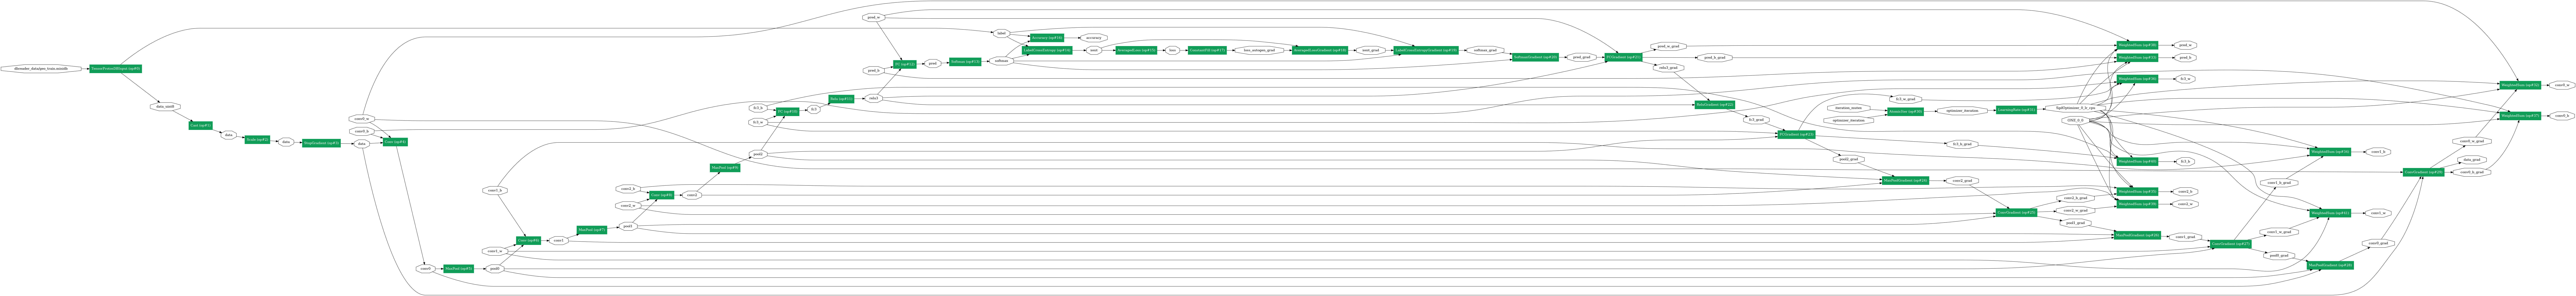

In [24]:
from IPython import display
graph = net_drawer.GetPydotGraph(train_model.net.Proto().op, "geo", rankdir="LR")
display.Image(graph.create_png(), width=800)

## Initialize the train model

In [25]:
# The parameter initialization network only needs to be run once.
# Now all the parameter blobs are initialized in the workspace.
workspace.RunNetOnce(train_model.param_init_net)

# Creating an actual network as a C++ object in memory.
#   We need this as the object is going to be used a lot
#   so we avoid creating an object every single time it is used.
# overwrite=True allows you to run this cell several times and avoid errors
workspace.CreateNet(train_model.net, overwrite=True)


True

### Train and track progress

In [26]:
# Set the iterations number and track the accuracy & loss
total_iters = 300
accuracy = []
loss = []

# MAIN TRAINING LOOP!
# Now, we will manually run the network for 200 iterations. 
for i in range(total_iters):
    workspace.RunNet(train_model.net)
    # Check the accuracy and loss every so often
    if i % 25 == 0:
        accuracy.append(workspace.blobs['accuracy'])
        loss.append(workspace.blobs['loss'])
        print("Iter: {}, Loss: {}, Accuracy: {}".format(i,loss[-1],accuracy[-1]))



Iter: 0, Loss: 1.96780014038, Accuracy: 0.140625
Iter: 25, Loss: 1.74782299995, Accuracy: 0.34375
Iter: 50, Loss: 1.68872773647, Accuracy: 0.328125
Iter: 75, Loss: 1.65956330299, Accuracy: 0.265625
Iter: 100, Loss: 1.69563221931, Accuracy: 0.140625
Iter: 125, Loss: 1.37148475647, Accuracy: 0.53125
Iter: 150, Loss: 1.52095174789, Accuracy: 0.375
Iter: 175, Loss: 1.73887991905, Accuracy: 0.28125
Iter: 200, Loss: 1.26796710491, Accuracy: 0.453125
Iter: 225, Loss: 1.67788922787, Accuracy: 0.28125
Iter: 250, Loss: 0.890563309193, Accuracy: 0.765625
Iter: 275, Loss: 1.14995920658, Accuracy: 0.515625


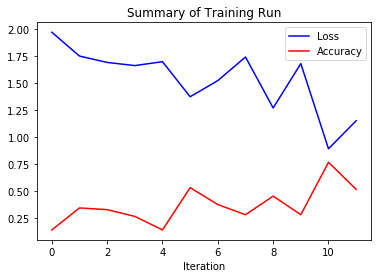

In [27]:
# After the execution is done, let's plot the values.
pyplot.plot(loss, 'b')
pyplot.plot(accuracy, 'r')
pyplot.title("Summary of Training Run")
pyplot.xlabel("Iteration")
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

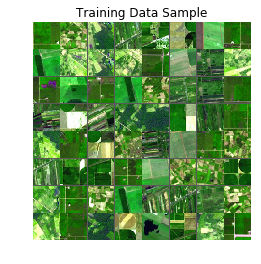

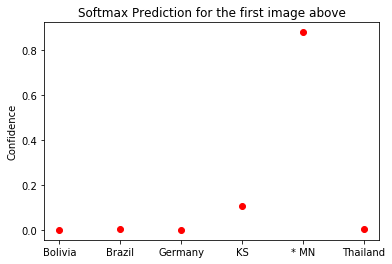

In [28]:
### Let's look at some of the training data
pyplot.figure()
pyplot.title("Training Data Sample")
# Grab the most recent data blob (i.e. batch) from the workspace
data = workspace.FetchBlob('data')
# Use visualize module to show the examples from the last batch that was fed to the model
_ = visualize.NCHW.ShowMultiple(data)

### Let's visualize the softmax result
pyplot.figure()
pyplot.title('Softmax Prediction for the first image above')
pyplot.ylabel('Confidence')

# Grab and visualize the softmax blob for the batch we just visualized. Since batch size
#  is 64, the softmax blob contains 64 vectors, one for each image in the batch. To grab
#  the vector for the first image, we can simply index the fetched softmax blob at zero.
softmax = workspace.FetchBlob('softmax')
truth = workspace.FetchBlob('label')
ticks = sorted(loc2id)
showidx = 0
ticks[truth[showidx]] = '* %s'%ticks[truth[showidx]]
pyplot.xticks(range(len(loc2id)),ticks)
_ = pyplot.plot(softmax[showidx], 'ro')

In [29]:
# param_init_net here will only create a data reader
# Other parameters won't be re-created because we selected init_params=False before
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)

True

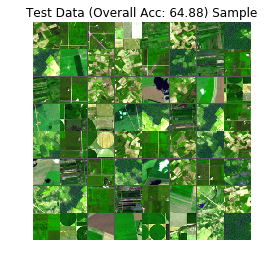

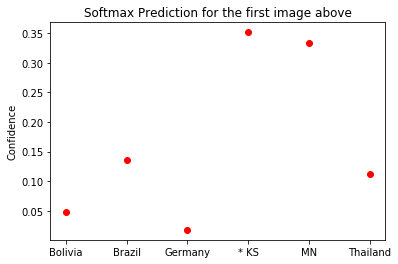

In [64]:
workspace.RunNet(test_model.net)
test_accuracy = workspace.FetchBlob('accuracy')

### Let's look at some of the training data
pyplot.figure()
pyplot.title("Test Data (Overall Acc: %.2f) Sample"%(100*test_accuracy))
# Grab the most recent data blob (i.e. batch) from the workspace
data = workspace.FetchBlob('data')
# Use visualize module to show the examples from the last batch that was fed to the model
_ = visualize.NCHW.ShowMultiple(data[:64])

### Let's visualize the softmax result
pyplot.figure()
pyplot.title('Softmax Prediction for the first image above')
pyplot.ylabel('Confidence')

# Grab and visualize the softmax blob for the batch we just visualized. Since batch size
#  is 64, the softmax blob contains 64 vectors, one for each image in the batch. To grab
#  the vector for the first image, we can simply index the fetched softmax blob at zero.
softmax = workspace.FetchBlob('softmax')
truth = workspace.FetchBlob('label')
ticks = sorted(loc2id)
showidx = 25
ticks[truth[showidx]] = '* %s'%ticks[truth[showidx]]
pyplot.xticks(range(len(loc2id)),ticks)
_ = pyplot.plot(softmax[showidx], 'ro')

In [62]:
zip(
    range(len(truth)),
    [id2loc[_] for _ in truth],
    [id2loc[_] for _ in preds]
)[:100]

[(0, u'Germany', u'Thailand'),
 (1, u'MN', u'MN'),
 (2, u'MN', u'MN'),
 (3, u'KS', u'Brazil'),
 (4, u'Thailand', u'Brazil'),
 (5, u'Germany', u'Bolivia'),
 (6, u'Thailand', u'KS'),
 (7, u'Bolivia', u'Brazil'),
 (8, u'Bolivia', u'Bolivia'),
 (9, u'Brazil', u'Brazil'),
 (10, u'Germany', u'Bolivia'),
 (11, u'Germany', u'Bolivia'),
 (12, u'MN', u'MN'),
 (13, u'Bolivia', u'Brazil'),
 (14, u'Thailand', u'Thailand'),
 (15, u'MN', u'MN'),
 (16, u'Thailand', u'Thailand'),
 (17, u'MN', u'MN'),
 (18, u'Germany', u'Germany'),
 (19, u'Germany', u'Thailand'),
 (20, u'Brazil', u'KS'),
 (21, u'Germany', u'Thailand'),
 (22, u'Brazil', u'KS'),
 (23, u'KS', u'KS'),
 (24, u'Brazil', u'Brazil'),
 (25, u'KS', u'KS'),
 (26, u'KS', u'Bolivia'),
 (27, u'Brazil', u'Thailand'),
 (28, u'Bolivia', u'Bolivia'),
 (29, u'Thailand', u'Thailand'),
 (30, u'Bolivia', u'Bolivia'),
 (31, u'MN', u'MN'),
 (32, u'Bolivia', u'Bolivia'),
 (33, u'MN', u'KS'),
 (34, u'KS', u'KS'),
 (35, u'Germany', u'Germany'),
 (36, u'MN', u'MN'

In [38]:
# construct the model to be exported
# the inputs/outputs of the model are manually specified.
pe_meta = pe.PredictorExportMeta(
    predict_net=deploy_model.net.Proto(),
    parameters=[str(b) for b in deploy_model.params] + ['accuracy','loss','label'], 
    inputs=["data"],
    outputs=["softmax"],
)

# save the model to a file. Use minidb as the file format
pe.save_to_db("minidb", os.path.join(data_folder, "geo_model.minidb"), pe_meta)
print("Deploy model saved to: " + data_folder + "/geo_model.minidb")

Deploy model saved to: data/geo_model.minidb
